In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
from sklearn.metrics import root_mean_squared_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
trn = pd.read_csv("../data/processed/trn.feat.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.feat.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.feat.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.feat.csv")

trn_y, trn_X = trn["Solubility"], trn.drop(["Solubility", "Name", "SMILES"], axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)

In [3]:
tune_space = {
    "eta": hp.choice("eta", [0.01, 0.1, 0.3]),
    "gamma": hp.uniform("gamma", 1, 9),
    "alpha": hp.quniform("alpha", 40, 180, 1),
    "lambda": hp.uniform("lambda", 0, 1),
    "max_depth": hp.randint("max_depth", 6, 10),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),

    "objective": "reg:squarederror",

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "booster": "gbtree",  # ["gbtree", "gblinear", "dart"]
    "eval_metric": "rmse",
    "tree_method": "auto",  # ["auto", "hist", "exact", "approx"]

    "num_boost_round": hp.choice("num_boost_round", [100, 200, 300]),
    "nfold": 5
}

In [4]:
def tune_obj(space):
    eval_history = xgb.cv(
        params={
            "eta": space["eta"],
            "gamma": space["gamma"],
            "alpha": space["alpha"],
            "lambda": space["lambda"],
            "max_depth": space["max_depth"],
            "min_child_weight": space["min_child_weight"],
            "colsample_bytree": space["colsample_bytree"],

            "objective": space["objective"],

            "device": space["device"],
            "booster": space["booster"],
            "eval_metric": space["eval_metric"],
            "tree_method": space["tree_method"]
        },
        dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
        num_boost_round=space["num_boost_round"],
        metrics=space["eval_metric"],
        nfold=space["nfold"]
    )
    return {
        "loss": min(eval_history["test-rmse-mean"]),
        'status': STATUS_OK
    }

In [5]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

100%|██████████| 100/100 [57:03<00:00, 34.23s/trial, best loss: 0.7209120453022697] 


In [6]:
best_params

{'alpha': 40.0,
 'colsample_bytree': 0.7736529640013535,
 'eta': 1,
 'gamma': 1.1475022441592932,
 'lambda': 0.469965504825428,
 'max_depth': 9,
 'min_child_weight': 7.0,
 'num_boost_round': 1}

In [4]:
best_params = {
    "eta": 0.01,
    "gamma": 1.1055210927423804,
    "alpha": 40.0,
    "lambda": 0.7993390441866357,
    "max_depth": 9,
    "min_child_weight": 5.0,
    "colsample_bytree": 0.9960479463691504,

    "objective": "reg:squarederror",

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "tree_method": "auto",

    "num_boost_round": 200,
    "early_stopping_rounds": 10,
    "nfold": 5
}

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

pred_19t1, pred_19t2, pred_08t = [], [], []
feat_importance = []
boosters = []

for trn_idx, val_idx in kf.split(trn_X):
    tX, vX = trn_X.loc[trn_idx], trn_X.loc[val_idx]
    ty, vy = trn_y[trn_idx], trn_y[val_idx]
    booster = xgb.XGBRegressor(
        n_estimators=best_params["num_boost_round"],
        # max_depth=best_params["max_depth"],
        learning_rate=best_params["eta"],
        # objective="reg:squarederror",
        # booster=best_params["booster"],
        # tree_method=best_params["tree_method"],
        # gamma=best_params["gamma"],
        # min_child_weight=best_params["min_child_weight"],
        # colsample_bytree=best_params["colsample_bytree"],
        # reg_alpha=best_params["alpha"],
        # reg_lambda=best_params["lambda"],
        device=best_params["device"],
        # eval_metric=best_params["eval_metric"],
    )
    booster.fit(tX, ty, eval_set=[(vX, vy)], verbose=0)

    pred_validation = booster.predict(vX)
    print(f"rmse, {root_mean_squared_error(vy, pred_validation):.3f}, r2, {r2_score(vy, pred_validation):.3f}")

    pred_19t1.append(booster.predict(tst1_19SC_X))
    pred_19t2.append(booster.predict(tst2_19SC_X))
    pred_08t.append(booster.predict(tst_08SC_X))
    feat_importance.append(booster.get_booster().get_score())
    boosters.append(booster)

In [6]:
tst1_19SC_pred = np.mean(pred_19t1, axis=0)
tst2_19SC_pred = np.mean(pred_19t2, axis=0)
tst_08SC_pred = np.mean(pred_08t, axis=0)

In [7]:
performance = {
    "2019SC TST1 (RMSE)": root_mean_squared_error(tst1_19SC_y.values, tst1_19SC_pred),
    "2019SC TST2 (RMSE)": root_mean_squared_error(tst2_19SC_y.values, tst2_19SC_pred),
    "2008SC TST  (RMSE)": root_mean_squared_error(tst_08SC_y.values, tst_08SC_pred),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y.values, tst1_19SC_pred),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y.values, tst2_19SC_pred),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y.values, tst_08SC_pred),
}
performance

{'2019SC TST1 (RMSE)': 0.7876194693945008,
 '2019SC TST2 (RMSE)': 1.410360434159446,
 '2008SC TST  (RMSE)': 0.8806392072523054,
 '2019SC TST1 (R^2)': 0.48908611447723116,
 '2019SC TST2 (R^2)': 0.5055550695179818,
 '2008SC TST  (R^2)': 0.5788905504307762}

Text(0.5, 1.0, '08SC (XGBoost)   RMSE: 0.881, $R^2$: 0.579')

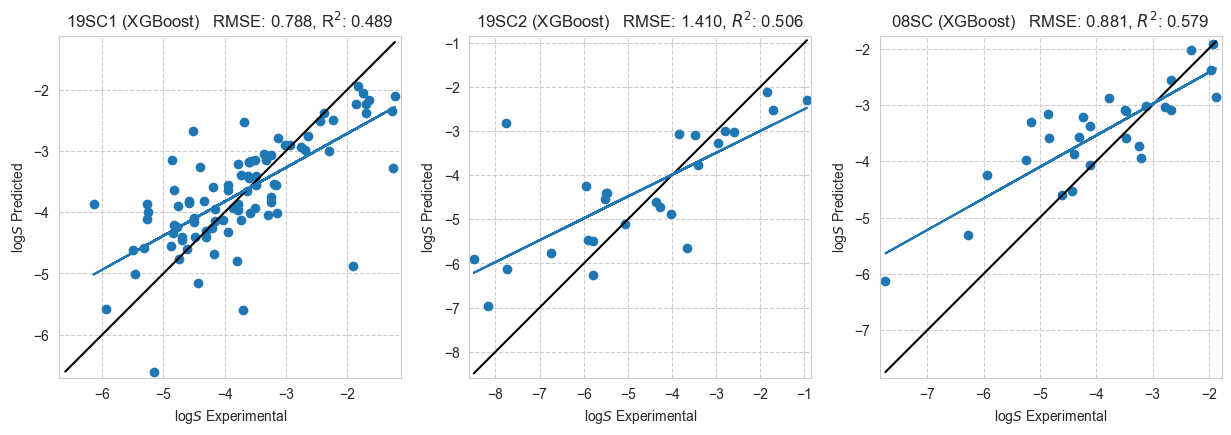

In [13]:
import matplotlib.pyplot as plt


def subplot(x, y, ax):
    ax.scatter(x, y)
    ax.set_xlim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    ax.set_ylim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    ax.grid(which='major', linestyle='--')
    ax.plot([min(min(x), min(y)), max(max(x), max(y))], [min(min(x), min(y)), max(max(x), max(y))], 'k')
    a, b = np.polyfit(x, y, 1)
    y_fit = a * x + b
    ax.plot(x, y_fit)
    ax.set_xlabel("log$S$ Experimental")
    ax.set_ylabel("log$S$ Predicted")


model_name = "XGBoost"

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))

subplot(tst1_19SC_y.values, tst1_19SC_pred, ax1)
subplot(tst2_19SC_y.values, tst2_19SC_pred, ax2)
subplot(tst_08SC_y.values, tst_08SC_pred, ax3)

ax1.set_title(f"19SC1 ({model_name})   "
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"R$^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"19SC2 ({model_name})   "
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"08SC ({model_name})   "
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")

Feature importance according to tree split.

In [8]:
feat_importance = pd.DataFrame(feat_importance).fillna(0)
feat_importance_mean = feat_importance.mean(axis=0)

In [9]:
# zero-importance features are not be included
# i.e. those features that have not been used in any split conditions.
min_v, max_v = feat_importance.min().min(), feat_importance.max().max()
feat_importance_sort = ((feat_importance - min_v) / (max_v - min_v))[
    feat_importance_mean.sort_values(ascending=False).index].T  # normalization
feat_importance_sort

,0,1,2,3,4,5,6,7,8,9
CDKXLogP,0.985270,0.851064,0.841244,0.921440,0.806874,0.779051,1.000000,0.869067,0.875614,0.872340
Rdkit2DMolLogP,0.566285,0.618658,0.590835,0.654664,0.515548,0.687398,0.490998,0.518822,0.574468,0.499182
MW,0.330606,0.545008,0.446809,0.415712,0.535188,0.315876,0.518822,0.461538,0.418985,0.399345
MordredFilterItLogS,0.288052,0.531915,0.499182,0.407529,0.432079,0.379705,0.432079,0.410802,0.392799,0.405892
MordredRNCG,0.420622,0.492635,0.435352,0.405892,0.399345,0.443535,0.312602,0.458265,0.407529,0.404255
...,...,...,...,...,...,...,...,...,...,...
Rdkit2Dfr_ketone,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001637,0.000000,0.000000,0.000000
Circular1267,0.000000,0.000000,0.000000,0.000000,0.000000,0.001637,0.000000,0.000000,0.000000,0.000000
Circular561,0.000000,0.000000,0.000000,0.000000,0.000000,0.001637,0.000000,0.000000,0.000000,0.000000
MordredSare,0.000000,0.000000,0.000000,0.000000,0.000000,0.001637,0.000000,0.000000,0.000000,0.000000


In [18]:
# append those zero-importance features
zero_importance = pd.DataFrame(index=list(set(trn_X.columns) - set(feat_importance_sort.index)),
                               columns=feat_importance_sort.columns)
zero_importance = zero_importance.fillna(0)
pd.concat([feat_importance_sort, zero_importance]).to_csv("../data/feats.importance.xgboost.csv")

C:\Users\ecbur\AppData\Local\Temp\ipykernel_34096\1809293492.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  zero_importance = zero_importance.fillna(0)


Permutation feature importance using test sets for supervised.

In [ ]:
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0)
tst_y = pd.concat([tst_08SC_y, tst1_19SC_y, tst2_19SC_y], axis=0)

pis = []
for booster in boosters:
    pi = permutation_importance(booster, tst_X, tst_y, n_jobs=-1)
    pis.append(pi)

In [70]:
perm_importance = pd.concat([pd.DataFrame(pis[i].importances_mean) for i in range(len(pis))], axis=1)
perm_importance.index = trn_X.columns
perm_importance_mean = perm_importance.mean(axis=1)
min_v, max_v = perm_importance.min().min(), perm_importance.max().max()
perm_importance_sort = ((perm_importance - min_v) / (max_v - min_v)).loc[
    perm_importance_mean.sort_values(ascending=False).index]  # normalization
perm_importance_sort.to_csv("../data/feats.importance.xgboost.csv")
perm_importance_sort

SHAP feature importance. (Tree Explainer)

In [8]:
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0)
tst_y = pd.concat([tst_08SC_y, tst1_19SC_y, tst2_19SC_y], axis=0)

sis = []
for booster in boosters:
    explainer = shap.TreeExplainer(booster)
    si = explainer.shap_values(tst_X, tst_y)
    sis.append(si)

In [29]:
shap_importance = pd.concat([pd.DataFrame(np.abs(sis[i]).mean(axis=0)) for i in range(len(sis))], axis=1)
shap_importance.index = trn_X.columns
shap_importance_mean = shap_importance.mean(axis=1)
min_v, max_v = shap_importance.min().min(), shap_importance.max().max()
shap_importance_sort = ((shap_importance - min_v) / (max_v - min_v)).loc[
    shap_importance_mean.sort_values(ascending=False).index]  # normalization
shap_importance_sort.to_csv("../data/feats.importance.xgboost.csv")
shap_importance_sort

,0,0,0,0,0,0,0,0,0,0
CDKJPLogP,0.756428,0.785906,0.794694,0.712607,1.000000,0.880830,0.750977,0.930428,0.831066,0.891554
Rdkit2DMolLogP,0.599222,0.612991,0.595375,0.697323,0.424263,0.554830,0.577984,0.485143,0.580886,0.470341
MordredFilterItLogS,0.431156,0.528511,0.496242,0.571802,0.559011,0.529089,0.543133,0.513996,0.434055,0.539591
CDKXLogP,0.248756,0.193309,0.195683,0.194726,0.173565,0.145858,0.268507,0.171204,0.167577,0.188279
MordredpiPC3,0.179562,0.173369,0.104360,0.130700,0.232021,0.192324,0.213309,0.161743,0.159082,0.198586
...,...,...,...,...,...,...,...,...,...,...
Circular61,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular62,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular63,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular64,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Subsets of features.

In [3]:
feat_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="XGBoost (tree-split)", index_col=0)
perm_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="XGBoost (permutation)", index_col=0)
shap_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="XGBoost (shap tree-explainer)",
                                     index_col=0)

In [4]:
feat_importance_mean = feat_importance_sort.mean(axis=1).sort_index()
perm_importance_mean = perm_importance_sort.mean(axis=1).sort_index()
shap_importance_mean = shap_importance_sort.mean(axis=1).sort_index()
importance_rank = (feat_importance_mean + perm_importance_mean + shap_importance_mean).sort_values(
    ascending=False).index
importance_rank

Index(['CDKJPLogP', 'Rdkit2DMolLogP', 'MordredFilterItLogS', 'CDKXLogP',
       'MordredRNCG', 'MW', 'MordredpiPC3', 'MordredATSC6pe', 'MordredZMIC1',
       'Rdkit2Dqed',
       ...
       'Circular371', 'Circular372', 'Circular374', 'Circular375',
       'Circular376', 'Circular379', 'Circular38', 'Circular380',
       'Circular381', 'Circular958'],
      dtype='object', length=4480)

In [41]:
rmse_dict, r2_dict = {}, {}
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0)
tst_y = pd.concat([tst_08SC_y, tst1_19SC_y, tst2_19SC_y], axis=0)

for n in [5, 10, 15, 20, 30, 40, 60, 80,
          100, 110, 120, 130, 140, 150, 160, 180,
          200, 225, 250, 275, 300, 325, 350, 375, 400, 450, 500, 550,
          600, 650, 700, 750, 800, 850, 900, 950,
          1000, 1500, 2000, 2500, 3000, 3500, 4000]:
    rmse, r2 = [], []
    sub_trn_X = trn_X[importance_rank[:n]]

    for i in range(5):
        for trn_idx, val_idx in KFold(n_splits=5, shuffle=True).split(sub_trn_X):
            tX, vX = sub_trn_X.loc[trn_idx], sub_trn_X.loc[val_idx]
            ty, vy = trn_y[trn_idx], trn_y[val_idx]

            booster = xgb.XGBRegressor(
                n_estimators=best_params["num_boost_round"],
                # max_depth=best_params["max_depth"],
                learning_rate=best_params["eta"],
                # objective="reg:squarederror",
                # booster=best_params["booster"],
                # tree_method=best_params["tree_method"],
                # gamma=best_params["gamma"],
                # min_child_weight=best_params["min_child_weight"],
                # colsample_bytree=best_params["colsample_bytree"],
                # reg_alpha=best_params["alpha"],
                # reg_lambda=best_params["lambda"],
                device=best_params["device"],
                # eval_metric=best_params["eval_metric"],
            )
            booster.fit(tX, ty, eval_set=[(vX, vy)], verbose=False)

            tst_pred = booster.predict(tst_X[importance_rank[:n]])
            rmse.append(root_mean_squared_error(tst_y.values, tst_pred))
            r2.append(r2_score(tst_y.values, tst_pred))

    rmse_dict[n] = rmse
    r2_dict[n] = r2

In [78]:
rmse = pd.DataFrame(rmse_dict).melt(var_name="n_feats", value_name="rmse")
r2 = pd.DataFrame(r2_dict).melt(var_name="n_feats", value_name="r2")
rmse_mean = pd.DataFrame(rmse_dict).mean()
r2_mean = pd.DataFrame(r2_dict).mean()

Text(310, 0.4358165901318878, '300')

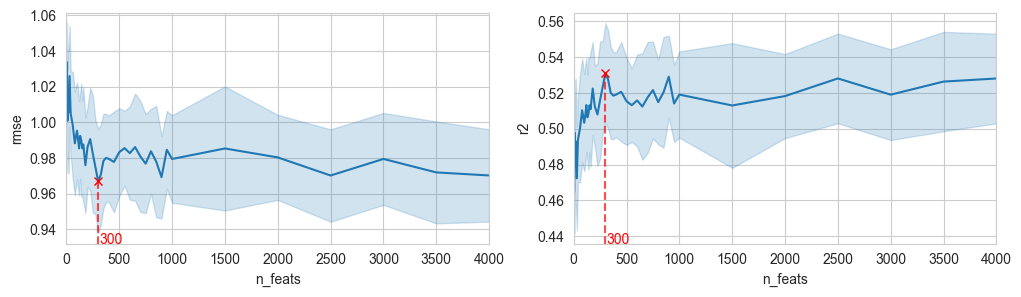

In [123]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))

sns.lineplot(rmse, x="n_feats", y="rmse", ax=ax1, errorbar="sd")
ax1.axvline(x=rmse_mean.idxmin(),
            ymin=0,
            ymax=(rmse_mean.min() - ax1.get_ylim()[0]) / (ax1.get_ylim()[1] - ax1.get_ylim()[0]),
            color='red', linestyle='--', alpha=0.7)
ax1.set_xlim(0, rmse["n_feats"].max())
ax1.plot(rmse_mean.idxmin(), rmse_mean.min(), 'rx')
ax1.text(int(rmse_mean.idxmin()) + 10, ax1.get_ylim()[0], f"{rmse_mean.idxmin()}", color='red')

sns.lineplot(r2, x="n_feats", y="r2", ax=ax2, errorbar="sd")
ax2.axvline(x=r2_mean.idxmax(),
            ymin=0,
            ymax=(r2_mean.max() - ax2.get_ylim()[0]) / (ax2.get_ylim()[1] - ax2.get_ylim()[0]),
            color='red', linestyle='--', alpha=0.7)
ax2.set_xlim(0, r2["n_feats"].max())
ax2.plot(r2_mean.idxmax(), r2_mean.max(), 'rx')
ax2.text(int(r2_mean.idxmax()) + 10, ax2.get_ylim()[0], f"{r2_mean.idxmax()}", color='red')

In [40]:
rmse.to_csv("xgboost.RMSE.csv")
r2.to_csv("xgboost.R2.csv")